## Capital Asset Pricing Model
https://github.com/hardikroutray/QuantitativeFinance/blob/main/CapitalAssetPricingModel.ipynb

### E(r$_{a}$) = r$_{f}$ + $\beta_{a}$ ( E[r$_{m}$] - r$_{f}$ ) 

where
### r$_{a}$ = return of a stock/portfolio, r$_{f}$ = risk-free return, E[r_{m}] - r$_{f}$ = market premium ( S&P 500 return - stock/portfolio return) 
### $\beta_{a}$ = Cov (r$_{a}$, r$_{m}$) / Var ( r$_{m}$ )

#### $\beta$ = 1 : stock/portfolio moving exactly with the market
#### $\beta$ > 1 : stock/portfolio is more volatile than the market
#### $\beta$ < 1 : stock/portfolio is less volatile than the market


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# market interest rate
RISK_FREE_RATE = 0.05
# we will consider monthly returns - and we want to calculate the annual return
MONTHS_IN_YEAR = 12

In [14]:
class CAPM:

    def __init__(self, stocks, start_date, end_date):
        self.data = None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date

    def download_data(self):
        data = {}

        for stock in self.stocks:
            ticker = yf.download(stock, self.start_date, self.end_date)
            data[stock] = ticker['Adj Close']

        return pd.DataFrame(data)

    def initialize(self):
        stock_data = self.download_data()
        # we use monthly returns instead of daily returns
        stock_data = stock_data.resample('M').last()

        self.data = pd.DataFrame({'s_adjclose': stock_data[self.stocks[0]],
                                  'm_adjclose': stock_data[self.stocks[1]]})

        # logarithmic monthly returns
        self.data[['s_returns', 'm_returns']] = np.log(self.data[['s_adjclose', 'm_adjclose']] /
                                                       self.data[['s_adjclose', 'm_adjclose']].shift(1))

        # remove the NaN values
        self.data = self.data[1:]

        display(self.data)

    def calculate_beta(self):
        # covariance matrix: the diagonal items are the variances
        # off diagonals are the covariances
        # the matrix is symmetric: cov[0,1] = cov[1,0] !!!
        covariance_matrix = np.cov(self.data["s_returns"], self.data["m_returns"])
        # calculating beta according to the formula
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
        print("Beta from formula: ", beta)

    def regression(self):
        # using linear regression to fit a line to the data
        # [stock_returns, market_returns] - slope is the beta
        beta, alpha = np.polyfit(self.data['m_returns'], self.data['s_returns'], deg=1)
        print("Beta from regression: ", beta)
        # calculate the expected return according to the CAPM formula
        # we are after annual return (this is why multiply by 12)
        expected_return = RISK_FREE_RATE + beta * (self.data['m_returns'].mean()*MONTHS_IN_YEAR
                                                   - RISK_FREE_RATE)
        print("Expected return after a year: ", expected_return)
        self.plot_regression(alpha, beta)

    def plot_regression(self, alpha, beta):
        fig, axis = plt.subplots(1, figsize=(20, 10))
        axis.scatter(self.data["m_returns"], self.data['s_returns'],
                     label="Data Points")
        axis.plot(self.data["m_returns"], beta * self.data["m_returns"] + alpha,
                  color='red', label="CAPM Line")
        plt.title('Capital Asset Pricing Model, finding alpha and beta')
        plt.xlabel('Market return $R_m$', fontsize=18)
        plt.ylabel('Stock return $R_a$', fontsize=18)
        plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show()

### Calculate $\beta$ for AAPL and use S&P 500 as market

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,s_adjclose,m_adjclose,s_returns,m_returns
Date,,,,
2010-02-28,6.239681,1104.489990,0.063347,0.028115
2010-03-31,7.166088,1169.430054,0.138431,0.057133
2010-04-30,7.961678,1186.689941,0.105280,0.014651
2010-05-31,7.833299,1089.410034,-0.016256,-0.085532
2010-06-30,7.670157,1030.709961,-0.021047,-0.055388
...,...,...,...,...
2022-05-31,148.633545,4132.149902,-0.056037,0.000053
2022-06-30,136.530350,3785.379883,-0.084937,-0.087652
2022-07-31,162.284576,4130.290039,0.172805,0.087201


Beta from formula:  1.122135491306861
Beta from regression:  1.1221354913068604
Expected return after a year:  0.10070243655372421


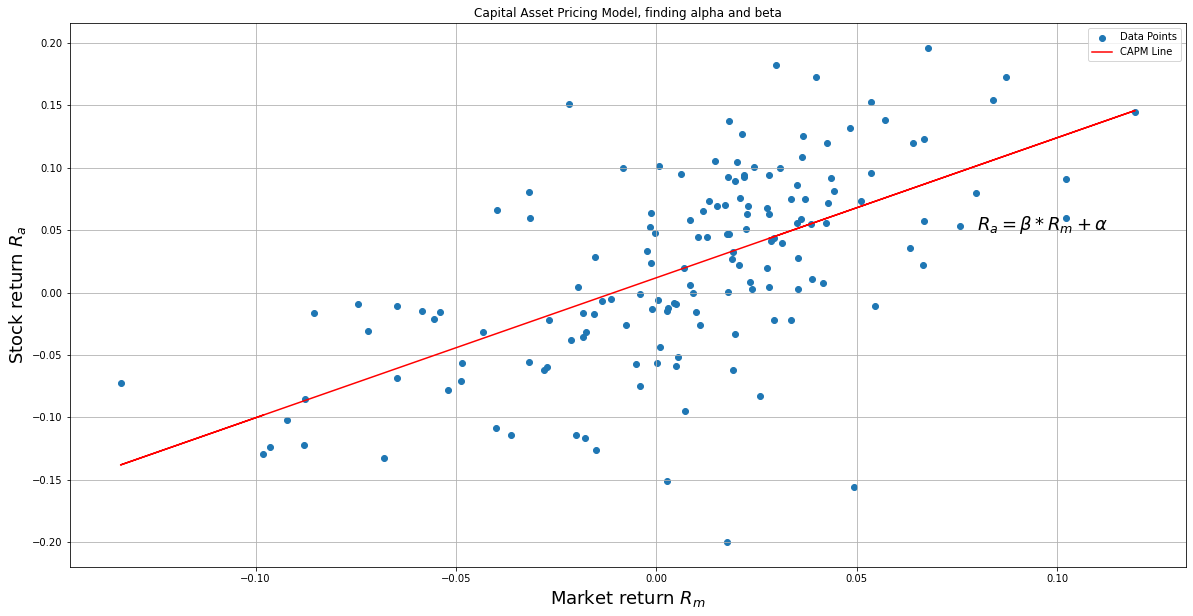

In [15]:
capm = CAPM(['AAPL', '^GSPC'], '2010-01-01', '2022-10-01')
capm.initialize()
capm.calculate_beta()
capm.regression()